In [1]:

import pandas as pd 
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.model_selection import StratifiedKFold,  GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import gc


In [2]:
def preprocessing_LETU(df):
    Y_var = df[['target','treat']]
    X_var = df.drop(['target','treat'], axis = 1)
    dataset = pd.DataFrame()
    ## Categorical to Vec
    dataset = pd.concat([dataset
                    , pd.get_dummies(X_var[['SEGMENT_N'
                                            ,	'SUB_EMAIL'
                                            , 'Тип карты'	
                                            , 'Канал регистрации'
                                            , 'NewComer']]
                                    )
                    ], axis = 1)
    X_var = X_var.drop(['SEGMENT_N'
                    ,'SUB_EMAIL'
                    , 'Тип карты'	
                    , 'Канал регистрации'
                    , 'NewComer'], axis =1)                    
    # dataset.head()

    ## Numeric preprocessing
    med = X_var['AGE'].median()
    dataset = pd.concat([dataset
                        , X_var['AGE'].apply(lambda x: x if((x >= 16) and (x <= 90)) else med).fillna(med)
                        ], axis=1)
    X_var = X_var.drop(['AGE'], axis =1)                     
    
    for_norm = ['lftm',	'AMOUNT'
            ,	'ORDERS'
            ,	'AOV'	
            ,'lftm_after_purch'
            ,'LTV_1M'
            , 'AO_per_month'
            , 'GET_Bonus'
            ,	'USE_Bonus'
            ,	'NON_SPEND_BONUS'
            ,	'BASE_GET_Bonus'
            ,	'BASE_USE_Bonus'
            ,	'Express_GET_Bonus'
            ,	'Express_USE_Bonus'
            ,	'Camp_GET_Bonus'
            ,	'REG_GET_Bonus'	
            , 'Camp_BASE_GET_Bonus'
            ,	'REG_BASE_GET_Bonus'
            , 'AVG_USE_BONUS'
            ,	'DISC_AMOUNT'
            ,	'DISC_ORDERS'
            , 'BASE_AVG_USE_BONUS'
            ,	'BASE_DISC_AMOUNT'
            ,	'BASE_DISC_ORDERS'
            , 'Express_AVG_USE_BONUS',	'Express_DISC_AMOUNT',	'Express_DISC_ORDERS']

    x_means = X_var[for_norm].mean()
    x_std = X_var[for_norm].std()  
    x_v = X_var[for_norm].copy() 
    dataset = pd.concat([dataset
                    , (x_v - x_means).fillna(0) / x_std
                    ], axis = 1)
    X_var = X_var.drop(for_norm, axis =1)      

    dataset = pd.concat([dataset
                    , X_var.fillna(0)] , axis = 1)
    del X_var   
    gc.collect()
    return dataset, Y_var  



In [3]:
def preprocessing_LETU_without_norm(df):
    Y_var = df[['target','treat']]
    X_var = df.drop(['target','treat'], axis = 1)
    dataset = pd.DataFrame()
    ## Categorical to Vec
    dataset = pd.concat([dataset
                    , pd.get_dummies(X_var[['SEGMENT_N'
                                            ,	'SUB_EMAIL'
                                            , 'Тип карты'	
                                            , 'Канал регистрации'
                                            , 'NewComer']]
                                    )
                    ], axis = 1)
    X_var = X_var.drop(['SEGMENT_N'
                    ,'SUB_EMAIL'
                    , 'Тип карты'	
                    , 'Канал регистрации'
                    , 'NewComer'], axis =1)                    
    # dataset.head()

    ## Numeric preprocessing
    med = X_var['AGE'].median()
    dataset = pd.concat([dataset
                        , X_var['AGE'].apply(lambda x: x if((x >= 16) and (x <= 90)) else med).fillna(med)
                        ], axis=1)
    X_var = X_var.drop(['AGE'], axis =1)                     
    
    for_norm = ['lftm',	'AMOUNT'
            ,	'ORDERS'
            ,	'AOV'	
            ,'lftm_after_purch'
            ,'LTV_1M'
            , 'AO_per_month'
            , 'GET_Bonus'
            ,	'USE_Bonus'
            ,	'NON_SPEND_BONUS'
            ,	'BASE_GET_Bonus'
            ,	'BASE_USE_Bonus'
            ,	'Express_GET_Bonus'
            ,	'Express_USE_Bonus'
            ,	'Camp_GET_Bonus'
            ,	'REG_GET_Bonus'	
            , 'Camp_BASE_GET_Bonus'
            ,	'REG_BASE_GET_Bonus'
            , 'AVG_USE_BONUS'
            ,	'DISC_AMOUNT'
            ,	'DISC_ORDERS'
            , 'BASE_AVG_USE_BONUS'
            ,	'BASE_DISC_AMOUNT'
            ,	'BASE_DISC_ORDERS'
            , 'Express_AVG_USE_BONUS',	'Express_DISC_AMOUNT',	'Express_DISC_ORDERS']


    x_v = X_var[for_norm].copy() 
    dataset = pd.concat([dataset
                    , x_v.fillna(0)
                    ], axis = 1)
    X_var = X_var.drop(for_norm, axis =1)      

    dataset = pd.concat([dataset
                    , X_var.fillna(0)] , axis = 1)
    del X_var   
    gc.collect()
    return dataset, Y_var  



# Обучение модели с CatBoost на данных с методом трансформации классов

In [4]:
df= pd.read_csv(r'uplift_dataset.zip'
                    , sep = ';'
                    , encoding = 'ANSI'
                    , dtype = {'NPL':str
                            , 'SEGMENT_N':str}, index_col=['NPL']).drop(['FEDERAL_DATE', 'Group', 'Send_DAte'], axis = 1)#.set_index('NPL')
df.index.name = None
X_data, Y_data = preprocessing_LETU(df)
display(X_data.head()) 
display(Y_data.head()) 
gc.collect()
from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)

from sklift.viz import plot_qini_curve, plot_uplift_curve, plot_uplift_by_percentile
import matplotlib.pyplot as plt

from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)

from sklift.viz import plot_qini_curve, plot_uplift_curve, plot_uplift_by_percentile
import matplotlib.pyplot as plt


C:\Users\Kirill\AppData\Local\Temp\ipykernel_2252\4102799322.py:1: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df= pd.read_csv(r'uplift_dataset.zip'


,NewComer,SEGMENT_N_1,SEGMENT_N_2,SEGMENT_N_3,SEGMENT_N_4,SEGMENT_N_5,SEGMENT_N_6,SEGMENT_N_8,SUB_EMAIL_Да,SUB_EMAIL_Нет,...,DISC_ORDERS,BASE_AVG_USE_BONUS,BASE_DISC_AMOUNT,BASE_DISC_ORDERS,Express_AVG_USE_BONUS,Express_DISC_AMOUNT,Express_DISC_ORDERS,AVG_DIS,BASE_AVG_DIS,Express_AVG_DIS
7709046080,0,1,0,0,0,0,0,0,1,0,...,-0.399003,0.000000,0.000000,0.000000,-0.653176,-0.693115,-0.299986,0.420668,0.000000,0.420668
7717101223,0,1,0,0,0,0,0,0,1,0,...,-0.399003,0.000000,0.000000,0.000000,0.612327,-0.450017,-0.299986,0.293083,0.000000,0.293083
7712715957,0,1,0,0,0,0,0,0,0,1,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7710968936,0,0,0,1,0,0,0,0,1,0,...,-0.399003,0.000000,0.000000,0.000000,0.612327,-0.067364,-0.299986,0.169262,0.000000,0.169262
7700742104,0,0,0,1,0,0,0,0,1,0,...,0.962821,2.775178,-0.398479,-0.374107,0.612327,0.000000,-0.299986,0.541446,0.247501,0.000000


,target,treat
7709046080,0,0
7717101223,0,0
7712715957,1,0
7710968936,0,0
7700742104,0,0


In [6]:

p = Y_data[Y_data.treat == 1].shape[0] / Y_data.shape[0]
X = X_data.values
y = Y_data.target * (Y_data.treat - p) / (1- p) / p
y = y.values
Y = np.array(list(zip(y, Y_data.treat.values)))
del df
gc.collect()
print(X)
print(y)
print(p)
# X_train, X_test, y_train, y_test = train_test_split(X, y)
# output.enable_custom_widget_manager()
# grid = {'learning_rate':  np.linspace(0, 0.05, 10)[1:-1],
#         'depth': [4, 6, 10],
#         'l2_leaf_reg': [1, 3, 5, 7, 9]}
# clf = CatBoostClassifier(verbose = 0)  
# grid_search_result = clf.grid_search(grid, 
#                                        X=X_train, 
#                                        y=y_train, 
#                                        plot=True)
from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)

from sklift.viz import plot_qini_curve, plot_uplift_curve, plot_uplift_by_percentile
import matplotlib.pyplot as plt


[[0.       1.       0.       ... 0.420668 0.       0.420668]
 [0.       1.       0.       ... 0.293083 0.       0.293083]
 [0.       1.       0.       ... 0.       0.       0.      ]
 ...
 [0.       0.       0.       ... 0.       0.       0.      ]
 [0.       0.       1.       ... 0.       0.       0.      ]
 [0.       1.       0.       ... 0.       0.       0.      ]]
[-0.         -0.         -2.00406899 ...  0.         -0.
  0.        ]
0.5010151832976517


In [8]:

X_train,X_test,y_tr,y_ts= train_test_split(X, Y)

In [9]:
y_train = y_tr.T[0]
treat_train = y_tr.T[1]

y_test = y_ts.T[0]
treat_test = y_ts.T[1]

In [10]:
rf = CatBoostRegressor(verbose = 0)# Instantiate the grid search model
#rf.fit(X_train, y_train)

In [11]:


grid = {
    'max_depth': [1, 2, 4, 6, 10, 20],
    'learning_rate': [0.03, 0.1, 0.02, 0.05, 0.01, 0.2, 0.3],
    'min_data_in_leaf': [1, 2, 3, 4, 6, 10],
    'n_estimators': [10, 50, 100, 1000]
}# Create a based model


grid_search_result = rf.grid_search(grid, 
                                       X=X_train, 
                                       y=y_train, 
                                       cv = 3,
                                       plot=True)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.5273404468
bestIteration = 9

0:	loss: 0.5273404	best: 0.5273404 (0)	total: 988ms	remaining: 16m 34s

bestTest = 0.5273185251
bestIteration = 9

1:	loss: 0.5273185	best: 0.5273185 (1)	total: 1.34s	remaining: 11m 13s

bestTest = 0.527347725
bestIteration = 9

2:	loss: 0.5273477	best: 0.5273185 (1)	total: 1.61s	remaining: 9m 1s

bestTest = 0.5273301919
bestIteration = 9

3:	loss: 0.5273302	best: 0.5273185 (1)	total: 1.88s	remaining: 7m 50s

bestTest = 0.5273568486
bestIteration = 9

4:	loss: 0.5273568	best: 0.5273185 (1)	total: 2.16s	remaining: 7m 13s

bestTest = 0.5273158927
bestIteration = 3

5:	loss: 0.5273159	best: 0.5273159 (5)	total: 2.48s	remaining: 6m 53s

bestTest = 0.5273217928
bestIteration = 3

6:	loss: 0.5273218	best: 0.5273159 (5)	total: 2.81s	remaining: 6m 41s

bestTest = 0.5273169734
bestIteration = 46

7:	loss: 0.5273170	best: 0.5273159 (5)	total: 4.1s	remaining: 8m 32s

bestTest = 0.5273123573
bestIteration = 26

8:	loss: 0.5273124	best: 0.5273124 (8)	tota

KeyboardInterrupt: 

In [ ]:
grid_search_result

{'params': {'min_data_in_leaf': 1,
  'depth': 10,
  'iterations': 50,
  'learning_rate': 0.05},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
            

In [ ]:
grid_search_result['params']

{'min_data_in_leaf': 1, 'depth': 10, 'iterations': 50, 'learning_rate': 0.05}

Best parameters<br>
{<br>'min_data_in_leaf': 1,<br> 'depth': 10,<br> 'iterations': 50,<br> 'learning_rate': 0.05<br>}

# Learning with best Params

In [20]:
df= pd.read_csv(r'uplift_dataset.zip'
                    , sep = ';'
                    , encoding = 'ANSI'
                    , dtype = {'NPL':str
                            , 'SEGMENT_N':str}, index_col=['NPL']).drop(['FEDERAL_DATE', 'Group', 'Send_DAte'], axis = 1)#.set_index('NPL')
df.index.name = None
X_data, Y_data = preprocessing_LETU(df)
display(X_data.head()) 
display(Y_data.head()) 
gc.collect()
from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)

from sklift.viz import plot_qini_curve, plot_uplift_curve, plot_uplift_by_percentile
import matplotlib.pyplot as plt

from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)

from sklift.viz import plot_qini_curve, plot_uplift_curve, plot_uplift_by_percentile
import matplotlib.pyplot as plt


,client_id,regular_points_received,express_points_received,regular_points_spent,express_points_spent,regular_balance,express_balance,Total_Amount,Amount_BonusDiscount_purchs,BonusDiscount,...,PArt_CTM_purchs,cnt_alc_purchs,cnt_CTM_purchs,Mean_diffs,first_order_date,age,LoveBonuses,Gender,treatment_flg,target
0,27159c9807,17.1,0.0,0.0,0.0,17.1,0.0,2950.17,0.00,0.000000,...,0.000000,0,0,10.0,2018-11-26 13:09:43,26.0,0,-1,0,1
1,b1b5ea0726,21.2,0.0,6.0,0.0,15.2,0.0,2334.64,190.75,0.030496,...,0.800000,0,4,19.0,2018-12-22 10:20:58,35.0,0,-1,1,0
2,8399c72ebf,26.2,0.0,0.0,0.0,26.2,0.0,4534.55,0.00,0.000000,...,0.444444,0,8,6.0,2018-11-25 09:49:15,23.0,2,0,1,0
3,d5b8aff1ad,13.7,0.0,0.0,0.0,13.7,0.0,2359.99,0.00,0.000000,...,0.538462,0,7,5.0,2019-01-15 09:59:17,69.0,0,-1,1,1
4,a6fd598f71,90.4,0.0,149.0,0.0,-58.6,0.0,8259.32,1014.49,0.128063,...,0.647059,0,11,6.0,2018-11-27 09:50:48,23.0,0,-1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200034,fecd01be95,6.4,0.0,0.0,0.0,6.4,0.0,1398.80,0.00,0.000000,...,0.555556,0,5,13.0,2018-11-28 18:36:33,73.0,0,0,1,0
200035,929c68106b,12.9,0.0,0.0,0.0,12.9,0.0,2051.93,0.00,0.000000,...,1.000000,2,4,34.0,2018-11-30 16:56:31,69.0,0,0,0,1
200036,f183f1a613,19.9,0.0,36.0,40.0,-16.1,-40.0,4271.41,426.61,0.151211,...,0.307692,3,4,6.0,2018-12-18 11:48:22,43.0,0,-1,0,1
200037,226757e95c,12.1,0.0,0.0,0.0,12.1,0.0,2737.92,0.00,0.000000,...,0.769231,1,10,8.0,2018-11-26 15:11:55,29.0,0,0,1,0


In [22]:

p = Y_data[Y_data.treat == 1].shape[0] / Y_data.shape[0]
X = X_data.values
y = Y_data.target * (Y_data.treat - p) / (1- p) / p
y = y.values
Y = np.array(list(zip(y, Y_data.treat.values)))
del df
gc.collect()
print(X)
print(y)
print(p)
# X_train, X_test, y_train, y_test = train_test_split(X, y)
# output.enable_custom_widget_manager()
# grid = {'learning_rate':  np.linspace(0, 0.05, 10)[1:-1],
#         'depth': [4, 6, 10],
#         'l2_leaf_reg': [1, 3, 5, 7, 9]}
# clf = CatBoostClassifier(verbose = 0)  
# grid_search_result = clf.grid_search(grid, 
#                                        X=X_train, 
#                                        y=y_train, 
#                                        plot=True)
from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)

from sklift.viz import plot_qini_curve, plot_uplift_curve, plot_uplift_by_percentile
import matplotlib.pyplot as plt


KeyError: "['MeanItemCost', 'client_id', 'Mean_TOP_1_BRAND', 'Mean_TOP_2_BRAND', 'Mean_TOP_3_BRAND', 'Mean_TOP_4_BRAND', 'Mean_TOP_5_BRAND', 'Mean_TOP_1_SEG', 'Mean_TOP_2_SEG', 'Mean_TOP_3_SEG', 'Mean_TOP_4_SEG', 'Mean_TOP_5_SEG', 'first_order_date'] not found in axis"

In [25]:
X_train,X_test,y_tr,y_ts= train_test_split(X, Y)


y_train = y_tr.T[0]
treat_train = y_tr.T[1]
targ_train = y_tr.T[2]

y_test = y_ts.T[0]
treat_test = y_ts.T[1]
targ_test = y_ts.T[2]


best_rf  = CatBoostRegressor(min_data_in_leaf=1, depth=10, iterations=50, learning_rate=0.05, verbose=0)
best_rf.fit(X_train, y_train)
y_pred = best_rf.predict(X_test)

WAU = 0.0307891690688769; UpLift 30% = 0.03959599488362464


c:\ProgramData\Anaconda3\envs\TuneSearch\lib\site-packages\numpy\core\fromnumeric.py:3156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


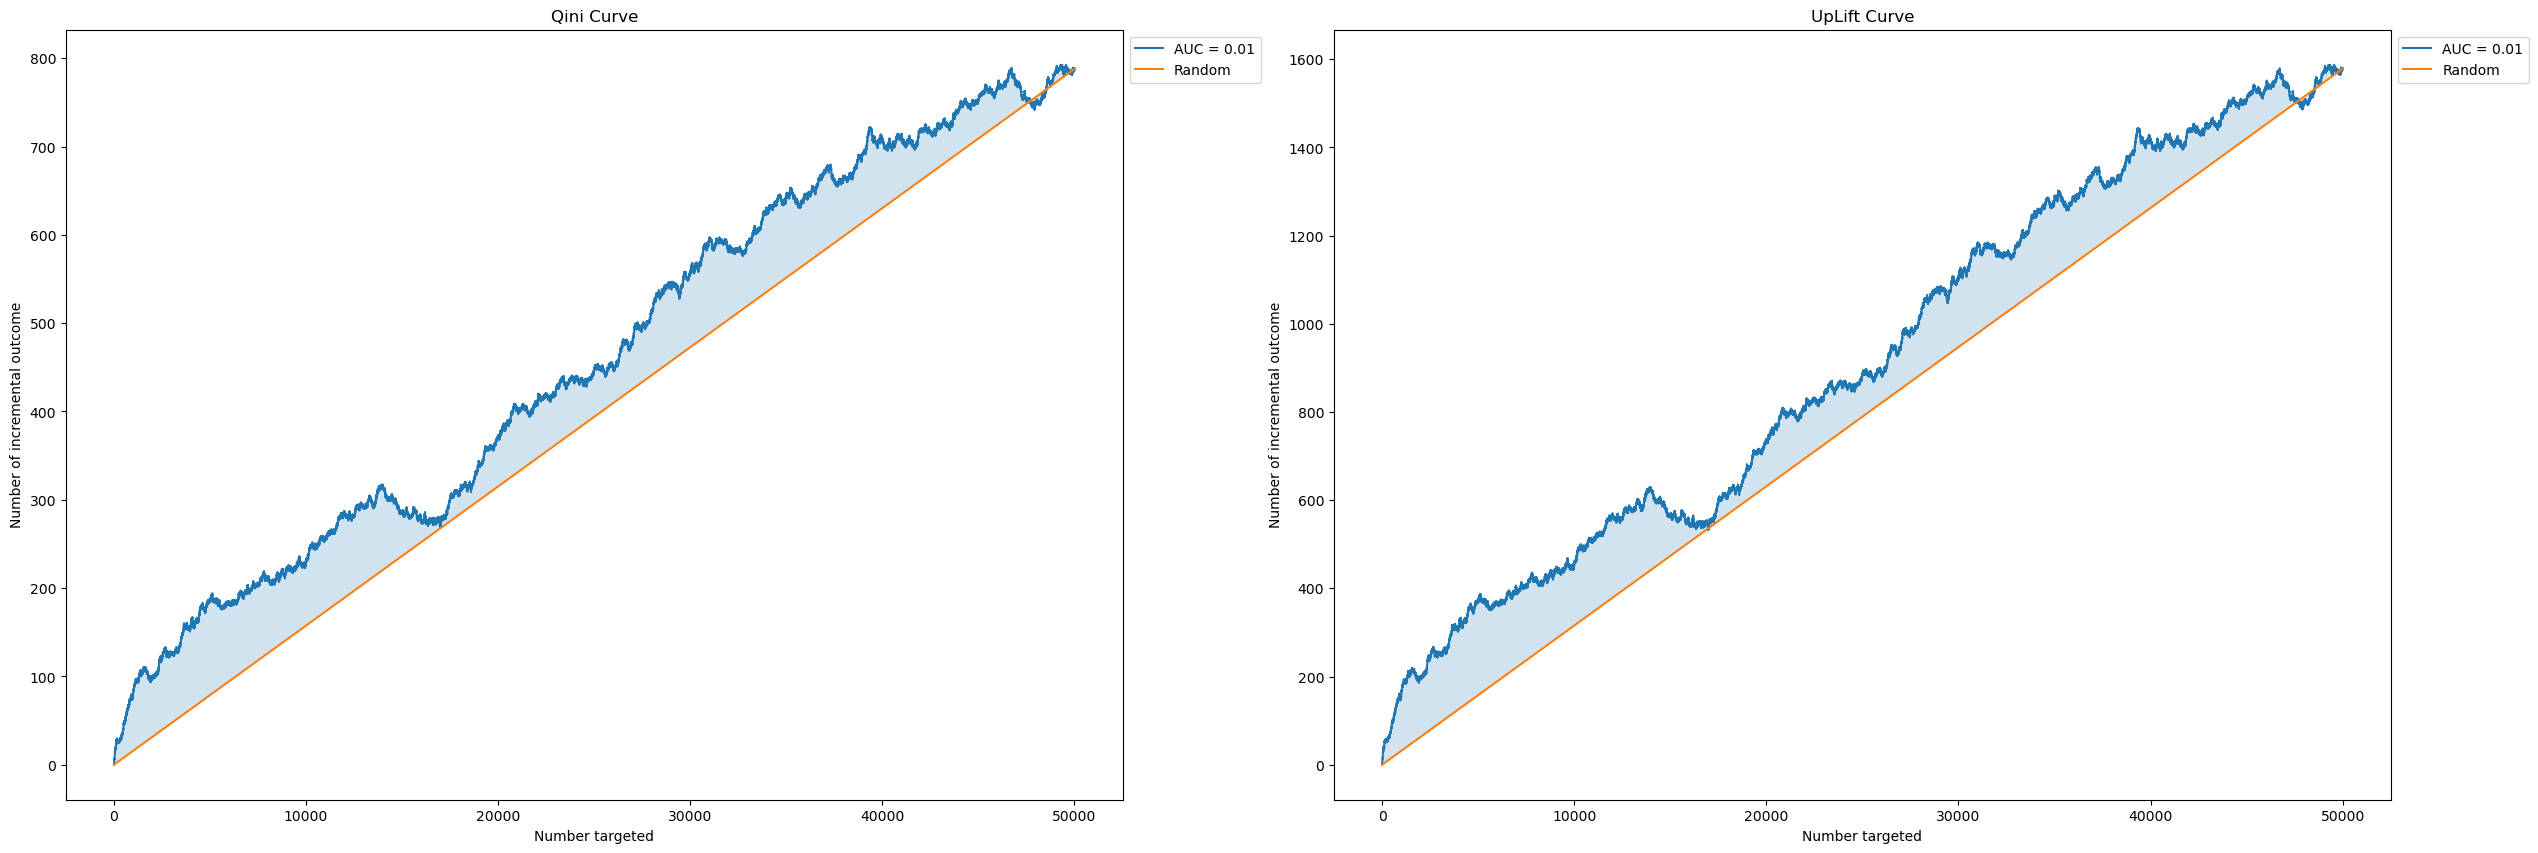

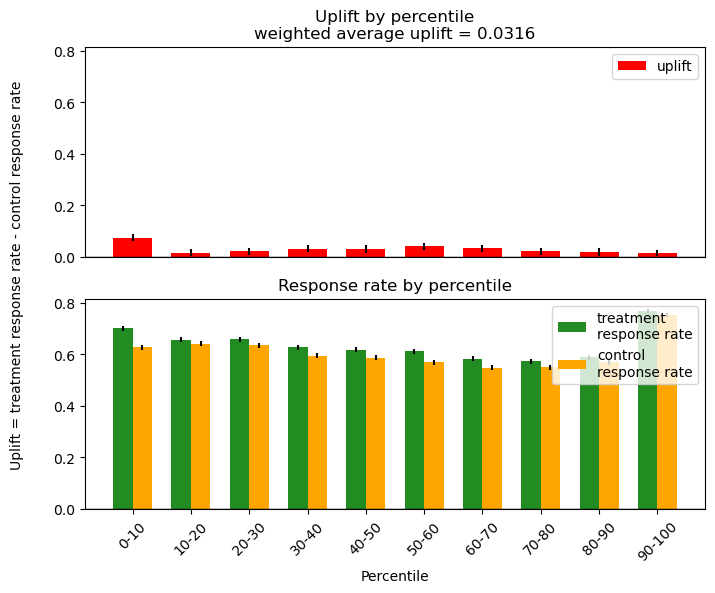

In [26]:
from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)

from sklift.viz import plot_qini_curve, plot_uplift_curve, plot_uplift_by_percentile
import matplotlib.pyplot as plt

wau = weighted_average_uplift(y_true=targ_test , uplift=y_pred
                              ,treatment=treat_test)
uplift_overall = uplift_at_k(y_true=targ_test , uplift=y_pred,
                              treatment= treat_test, strategy='by_group', k=0.3)

print(f'WAU = {wau}; UpLift 30% = {uplift_overall}')
fig, ax = plt.subplots(1, 2, figsize = (30, 10))
ax[0].set_title('Qini Curve')
ax[1].set_title('UpLift Curve')
plot_qini_curve(y_true=targ_test, uplift=y_pred,
                        treatment=treat_test, ax = ax[0], perfect=False)
gc.collect()
plot_uplift_curve(y_true=targ_test , uplift=y_pred,
                        treatment=treat_test, ax = ax[1], perfect=False)
gc.collect()
gc.collect()
gc.collect()
plt.savefig(f"Plots/Catboost_best_tune.png")

plot_uplift_by_percentile(y_true=targ_test, uplift=y_pred,
                        treatment=treat_test, kind='bar')
plt.savefig(f"Plots/Catboost_best_tune_Procentile.png")

Split 1; WAU = 0.03128081802727736; UpLift at 30% 0.05752565516919583


c:\ProgramData\Anaconda3\envs\TuneSearch\lib\site-packages\numpy\core\fromnumeric.py:3156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


Split 2; WAU = 0.032410487498018066; UpLift at 30% 0.04468436762014738


c:\ProgramData\Anaconda3\envs\TuneSearch\lib\site-packages\numpy\core\fromnumeric.py:3156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


Split 3; WAU = 0.03076164026069067; UpLift at 30% 0.05322073247863823


c:\ProgramData\Anaconda3\envs\TuneSearch\lib\site-packages\numpy\core\fromnumeric.py:3156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


Split 4; WAU = 0.03439901603214688; UpLift at 30% 0.05569873545633164


c:\ProgramData\Anaconda3\envs\TuneSearch\lib\site-packages\numpy\core\fromnumeric.py:3156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


Split 5; WAU = 0.03457528498089255; UpLift at 30% 0.042018110435663614


c:\ProgramData\Anaconda3\envs\TuneSearch\lib\site-packages\numpy\core\fromnumeric.py:3156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


Mean WAU = 0.0327; Mean UpLift 30% = 0.0506


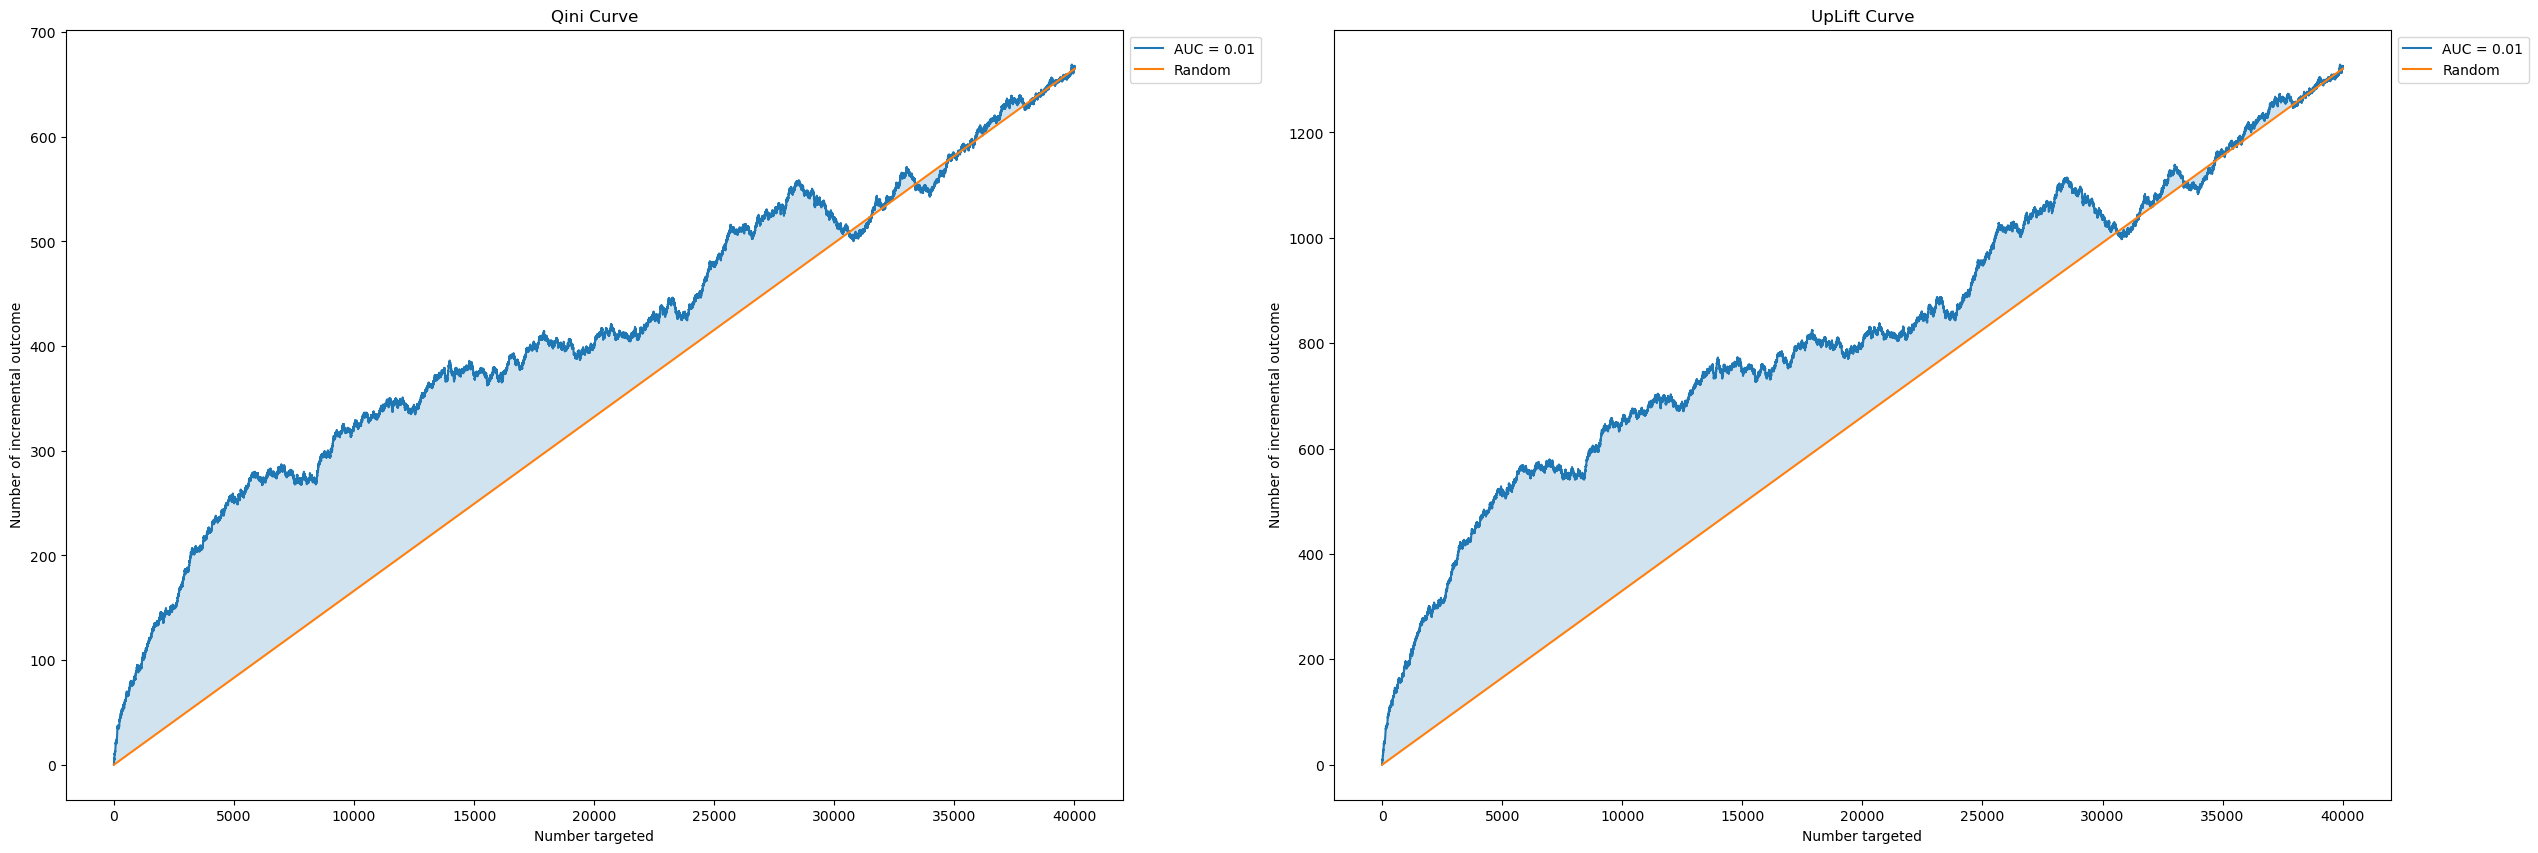

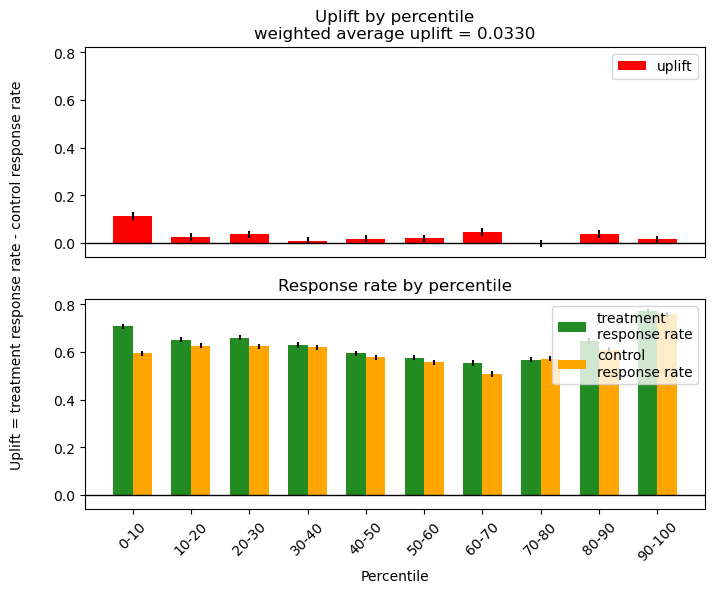

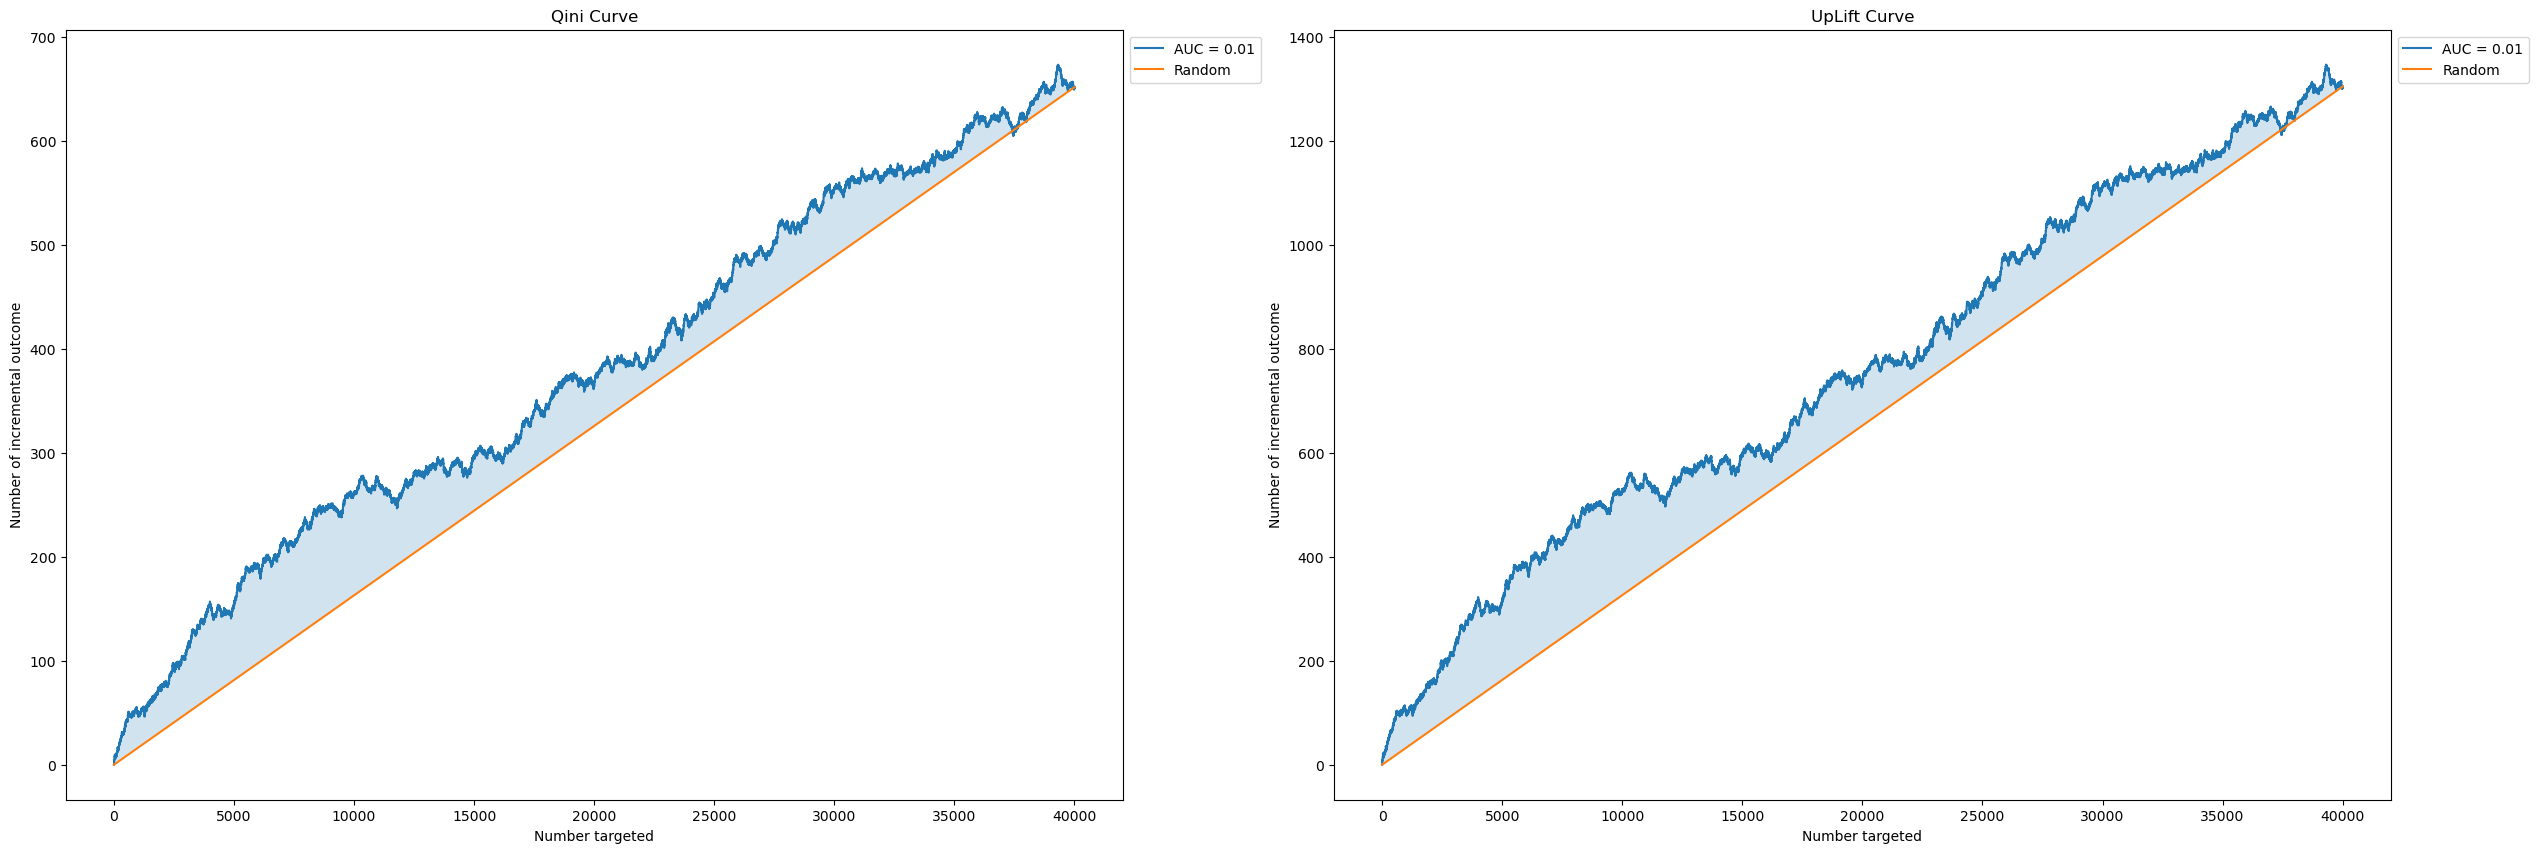

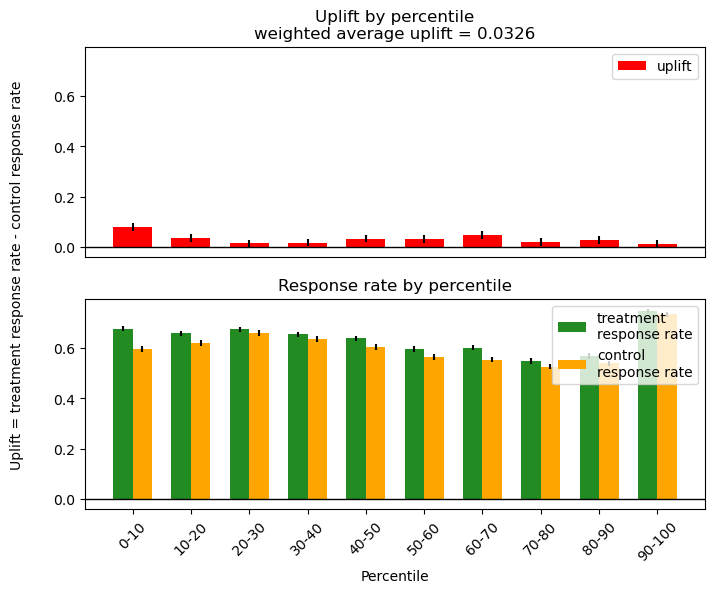

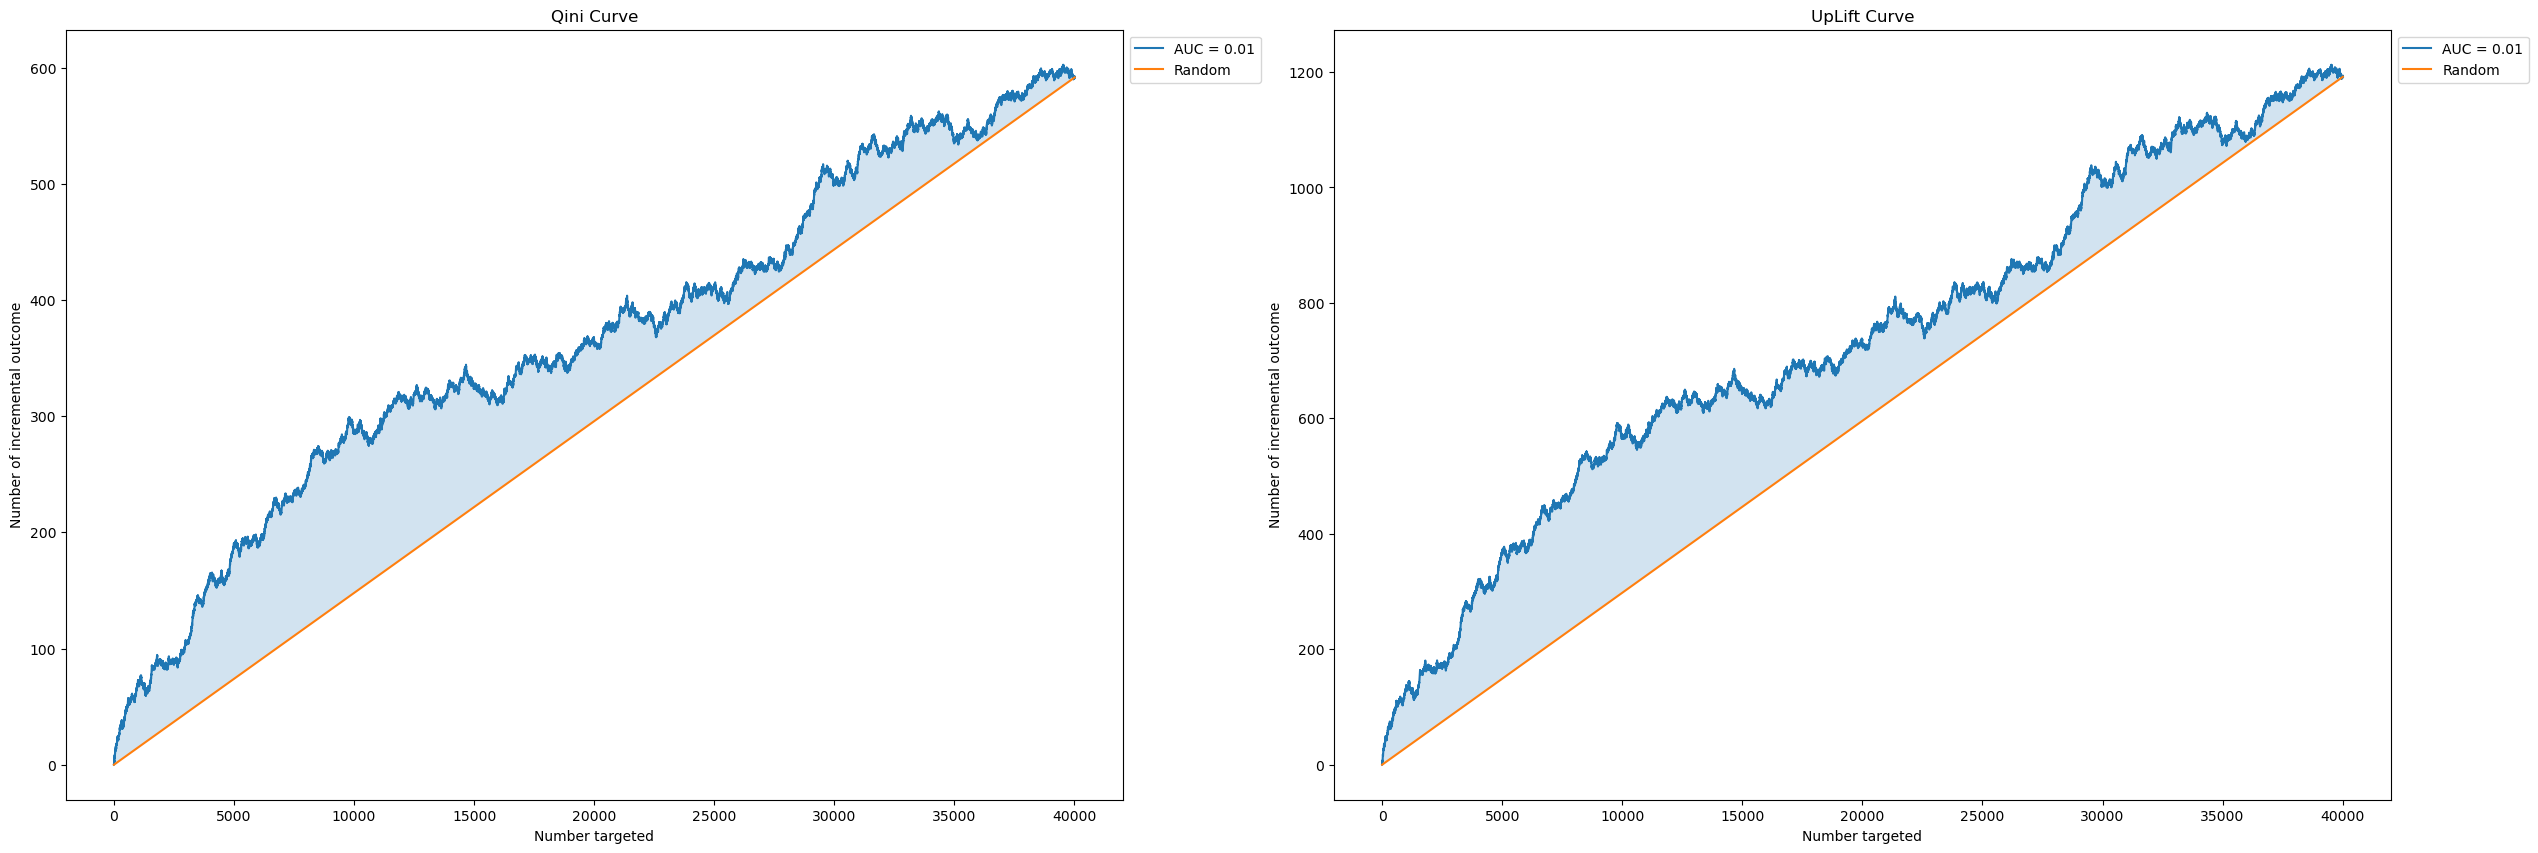

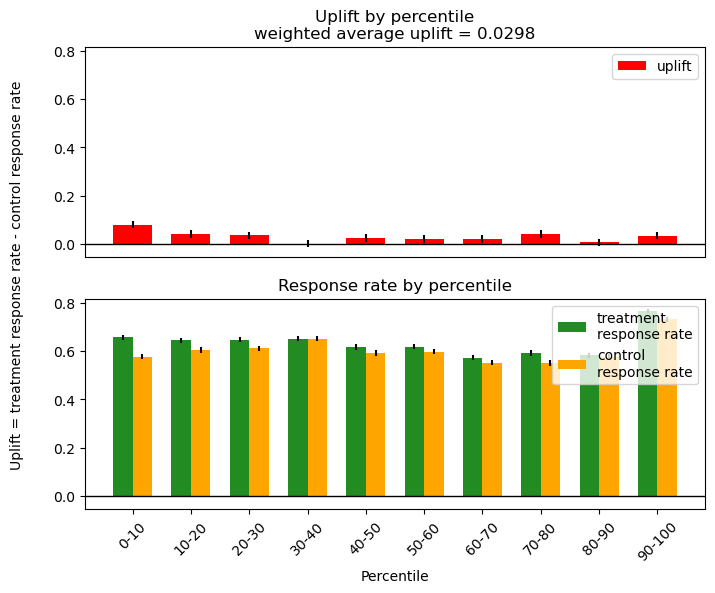

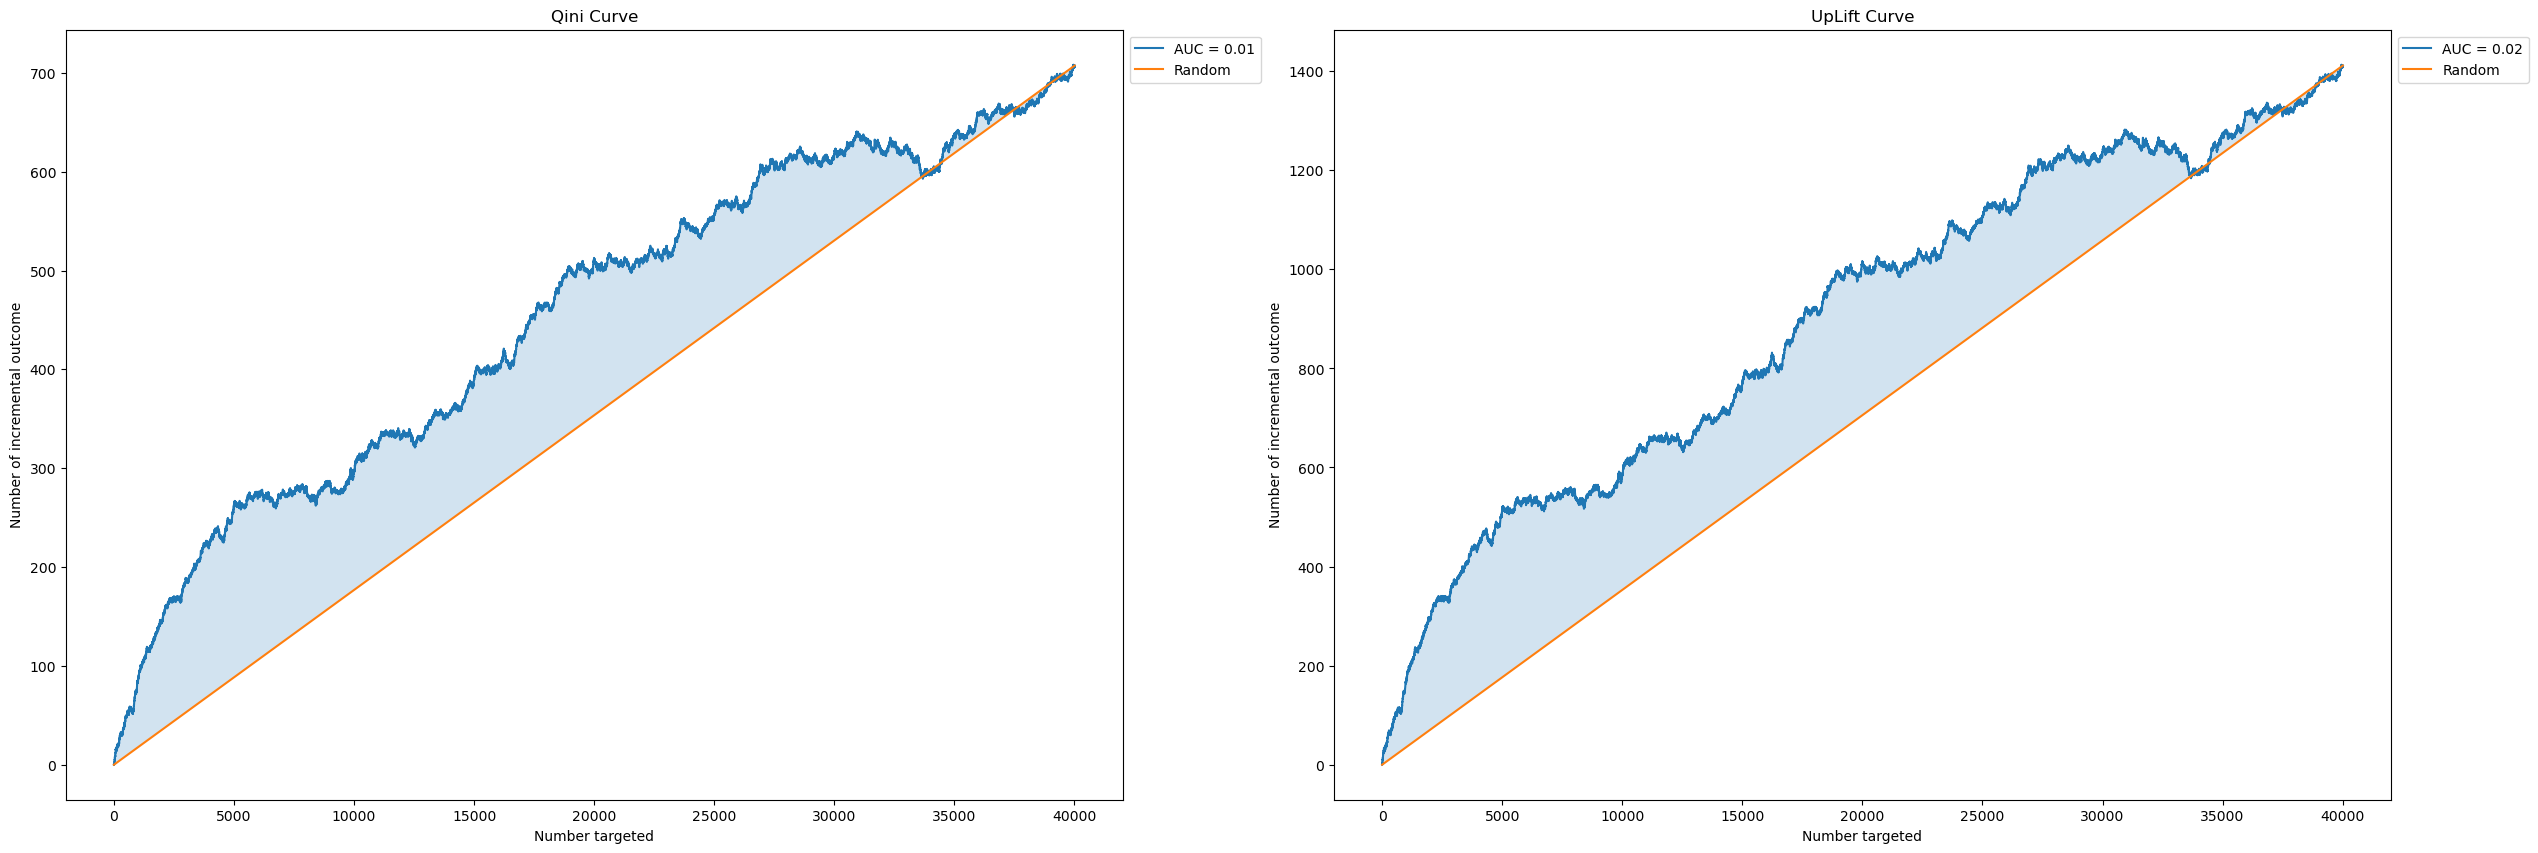

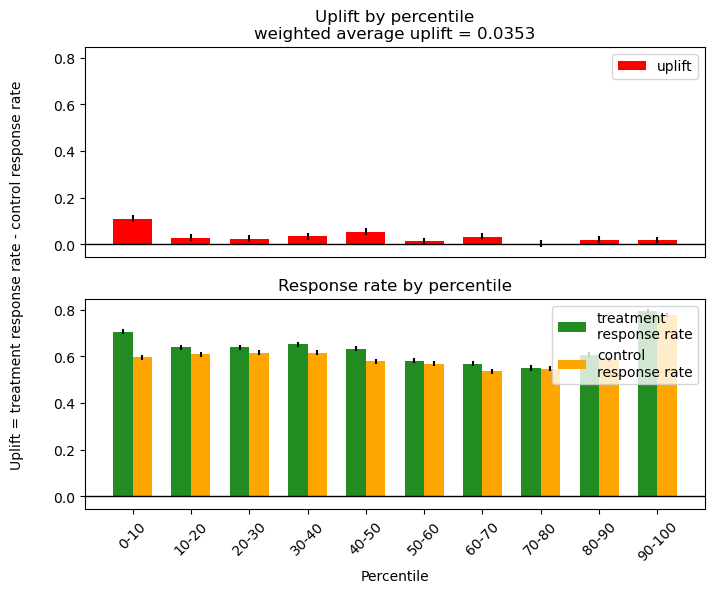

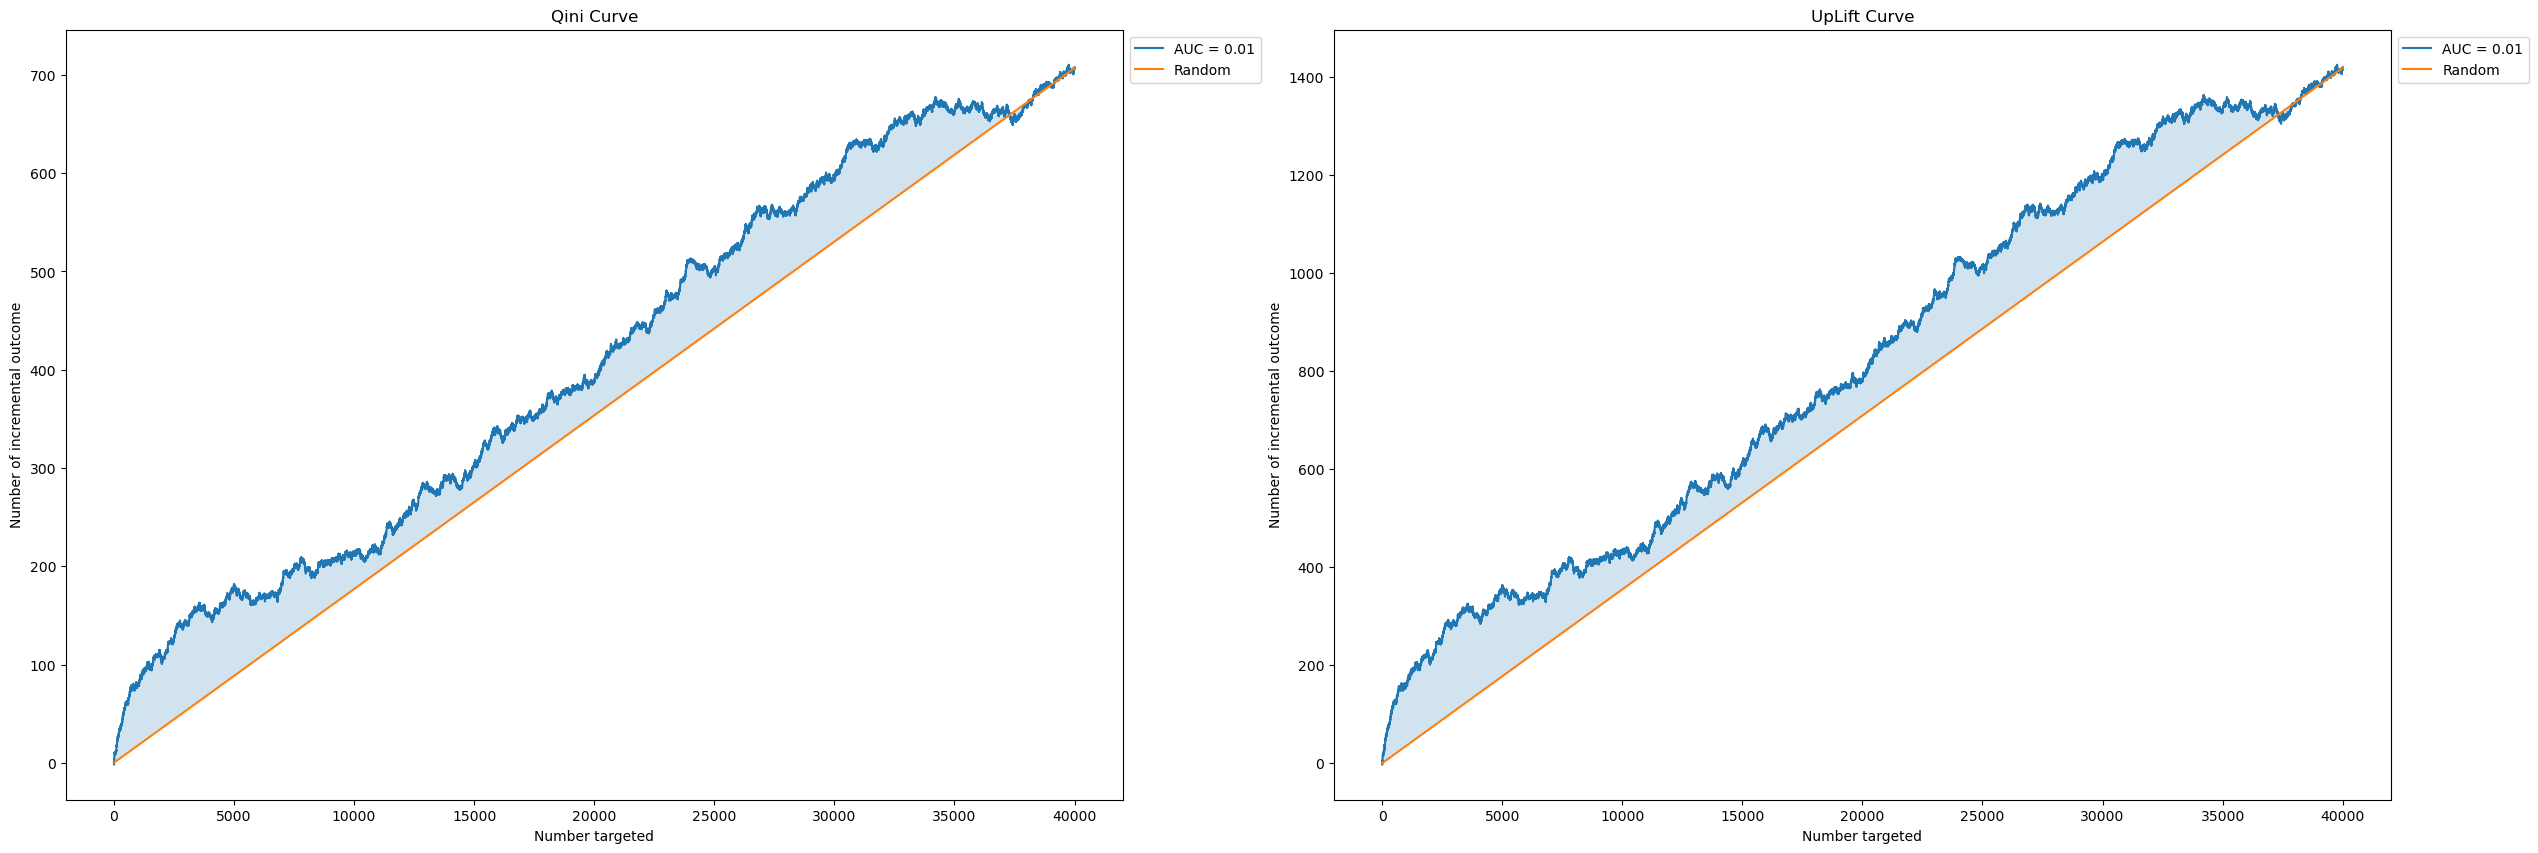

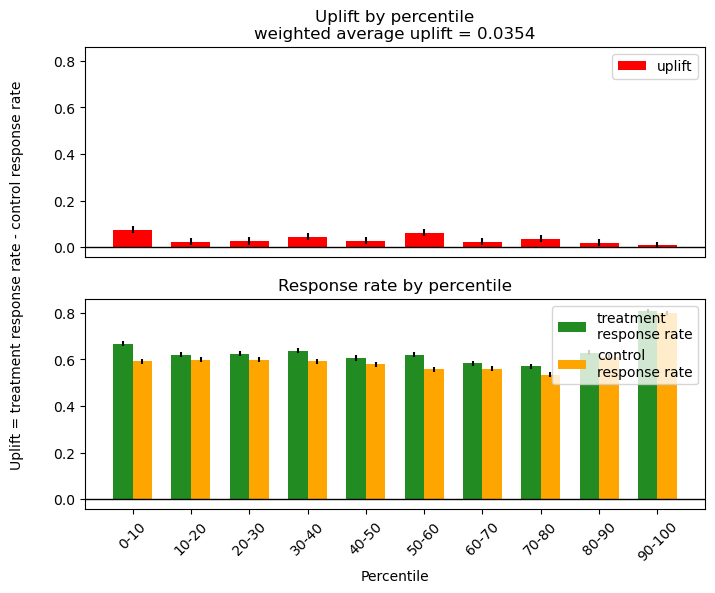

In [29]:




#Default data
skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X, y)
metrics = {'wau':[], 'uplift_k':[]}
i = 0

y = Y.T[0]
for train_index, test_index in skf.split(X, Y.T[2]):
      gc.collect()
      X_train_, X_test_ = X[train_index], X[test_index]
      y_train_, y_test_ = y[train_index], y[test_index]
      best_rf  = CatBoostRegressor(min_data_in_leaf=1, depth=10, iterations=50, learning_rate=0.05, verbose=0)
      best_rf.fit(X_train_, y_train_)
      y_pred = best_rf.predict(X_test_)
      del best_rf
      del X_train_
      del y_train_
      del X_test_
      gc.collect()
      wau = weighted_average_uplift(y_true= targ[test_index], uplift=y_pred,
                              treatment=treat[test_index])
      uplift_overall = uplift_at_k(y_true=targ[test_index] , uplift=y_pred,
                              treatment=treat[test_index], strategy='by_group', k=0.3)
      metrics['wau'].append(wau)
      metrics['uplift_k'].append(uplift_overall)
      i += 1
      print(f'Split {i}; WAU = {wau}; UpLift at 30% {uplift_overall}')
      fig, ax = plt.subplots(1, 2, figsize = (30, 10))
      ax[0].set_title('Qini Curve')
      ax[1].set_title('UpLift Curve')
      plot_qini_curve(y_true=targ[test_index] , uplift=y_pred,
                              treatment=treat[test_index], ax = ax[0], perfect=False)
      gc.collect()
      plot_uplift_curve(y_true=targ[test_index] , uplift=y_pred,
                              treatment=treat[test_index], ax = ax[1], perfect=False)
      gc.collect()
      gc.collect()
      gc.collect()
      plt.savefig(f"CatBoostPlots/One model Split {i}.png")

      plot_uplift_by_percentile(y_true=targ[test_index] , uplift=y_pred,
                              treatment=treat[test_index], kind='bar')
      plt.savefig(f"CatBoostPlots/One model Procentile Split {i}.png")


wau = np.round(np.mean(metrics['wau']), 4)
uplift_overall = np.round(np.mean(metrics['uplift_k']), 4)
print(f'Mean WAU = {wau}; Mean UpLift 30% = {uplift_overall}')

In [ ]:
gc.collect()

71372